In [1]:
# install prophet if you dont have it already 

# !pip install prophet

In [85]:
from prophet import Prophet

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 


In [3]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/rossmann_train.csv 

--2024-05-13 19:32:03--  https://lazyprogrammer.me/course_files/timeseries/rossmann_train.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38057952 (36M) [text/csv]
Saving to: 'rossmann_train.csv'

rossmann_train.csv  100%[===================>]  36.29M  14.3MB/s    in 2.5s    

2024-05-13 19:32:07 (14.3 MB/s) - 'rossmann_train.csv' saved [38057952/38057952]



In [86]:
df = pd.read_csv('rossmann_train.csv', low_memory=False)

In [87]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


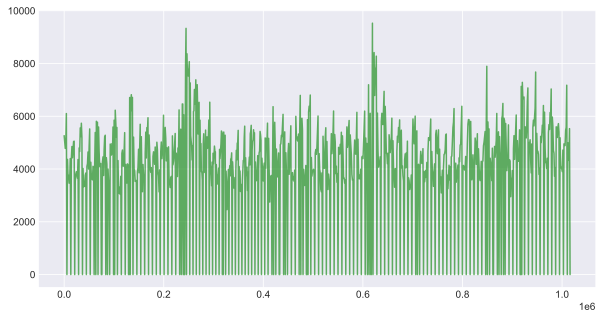

In [88]:
fig, axes = plt.subplots(figsize = (10,5))

df[df['Store'] == 1]['Sales'].plot(ax = axes, color = 'green', alpha = 0.6)

axes.grid()

There are lots of occurances (days) when the sales drop to zero! It could be that at those instances the store is closed for example.

In [89]:
(df[df['Store']==1]['Sales'] == 0).sum()

161

There are 161 such instances!

In [90]:
df_s1 = df[df['Store'] == 1].copy()

df_s1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1115,1,4,2015-07-30,5020,546,1,1,0,1
2230,1,3,2015-07-29,4782,523,1,1,0,1
3345,1,2,2015-07-28,5011,560,1,1,0,1
4460,1,1,2015-07-27,6102,612,1,1,0,1


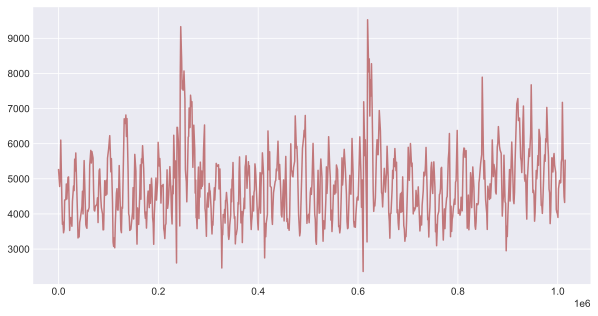

In [91]:
fig, axes = plt.subplots(figsize = (10,5))

df_s1[df_s1['Open'] > 0]['Sales'].plot(ax = axes, color = 'brown', alpha = 0.6)

axes.grid()

Time-series look more reasonable focusing on the number of sales on the days when the store is open. We dont have to model the sales when the store is closed as we know precisely that sales will be zero in that case. 

In [92]:
# check if the zero sales corresponds to zero customers and closed store

no_sales_idx = df_s1[df_s1['Sales'] == 0].index 
no_cust_idx = df_s1[df_s1['Customers'] == 0].index 
closed_store = df_s1[df_s1['Open'] == 0].index 

print(np.all(no_sales_idx == no_cust_idx))

print(np.all(no_cust_idx == closed_store))

True
True


These results imply that when the store is open, there will be non-zero sales and customers because all the instances when the store is closed is equivalent to no customers and no sales. 

In [93]:
# set the index of the df as 'Date' column which is a Dtype of object

# df_s1.info()

df_s1['Date'] = pd.to_datetime(df_s1['Date'])

df_s1.set_index('Date', inplace=True)

df_s1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


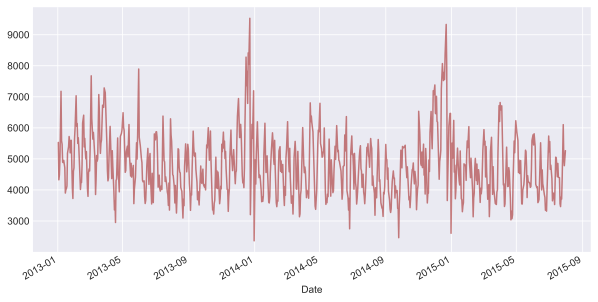

In [94]:
fig, axes = plt.subplots(figsize = (10,5))

df_s1[df_s1['Customers'] > 0]['Sales'].plot(ax = axes, color = 'brown', alpha = 0.6)

axes.grid()

In [95]:
# Now lets arrange the df in a way suitable for Prophet which can handle uni-variate time-series ('y') with a timestamp called 'ds' that is also a column (not an index)

df_s1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


In [96]:
df_p = df_s1[['Sales']].copy()

df_p['Date'] = df_s1.index

df_p.sort_index(inplace=True) # sort the timestamp vals as they are in descending order at the moment


In [97]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Sales   942 non-null    int64         
 1   Date    942 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.1 KB


In [98]:
df_p.head()

,Sales,Date
Date,,
2013-01-01,0,2013-01-01
2013-01-02,5530,2013-01-02
2013-01-03,4327,2013-01-03
2013-01-04,4486,2013-01-04
2013-01-05,4997,2013-01-05


In [99]:
# We can see 0 zero sales corresponding to holidays (like new years eve) and sundays
# We can remove these data points as well however Prophet has no problem with 'missing' data because the only regressor is time 
# this also means that there is no need for your time series to be recorded at regularly spaced intervals 

df_p.columns = ['y', 'ds']

df_p.head(20)

,y,ds
Date,,
2013-01-01,0,2013-01-01
2013-01-02,5530,2013-01-02
2013-01-03,4327,2013-01-03
2013-01-04,4486,2013-01-04
2013-01-05,4997,2013-01-05
2013-01-06,0,2013-01-06
2013-01-07,7176,2013-01-07
2013-01-08,5580,2013-01-08
2013-01-09,5471,2013-01-09


In [100]:
# initiate Prophet and fit 

m = Prophet()

m.fit(df_p)

18:16:40 - cmdstanpy - INFO - Chain [1] start processing
18:16:40 - cmdstanpy - INFO - Chain [1] done processing


In [101]:
# to make predictions we first make a future_df that only contains the timestamps of in sample and out of sample data for the next year

future_df = m.make_future_dataframe(periods = 365) 

future_df.tail()

,ds
1302,2016-07-26
1303,2016-07-27
1304,2016-07-28
1305,2016-07-29
1306,2016-07-30


In [102]:
# predict to return a df of forecast

forecast = m.predict(future_df)

forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1302,2016-07-26,3728.074139,2939.125897,5819.328073,3702.489910,3756.799305,714.084186,714.084186,714.084186,706.289377,706.289377,706.289377,7.794809,7.794809,7.794809,0.0,0.0,0.0,4442.158325
1303,2016-07-27,3727.845746,2880.057972,5701.478245,3702.183734,3756.726460,503.173286,503.173286,503.173286,510.541176,510.541176,510.541176,-7.367890,-7.367890,-7.367890,0.0,0.0,0.0,4231.019032
1304,2016-07-28,3727.617352,2366.096014,5274.489126,3701.868674,3756.647008,127.119582,127.119582,127.119582,151.288442,151.288442,151.288442,-24.168860,-24.168860,-24.168860,0.0,0.0,0.0,3854.736935
1305,2016-07-29,3727.388959,2888.225384,5703.934468,3701.523579,3756.564480,531.396934,531.396934,531.396934,573.669761,573.669761,573.669761,-42.272827,-42.272827,-42.272827,0.0,0.0,0.0,4258.785893
1306,2016-07-30,3727.160566,3256.943180,6114.587220,3701.161702,3756.373487,937.798260,937.798260,937.798260,999.122114,999.122114,999.122114,-61.323854,-61.323854,-61.323854,0.0,0.0,0.0,4664.958826


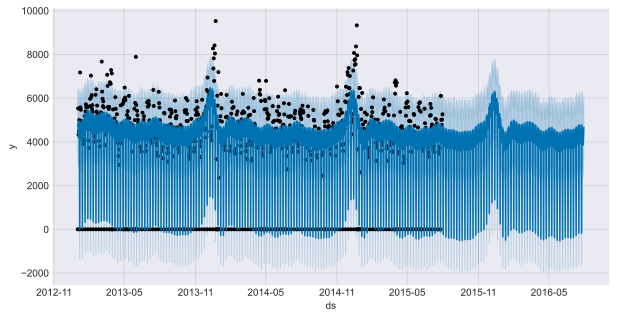

In [103]:
fig, axes = plt.subplots(figsize = (10,5))

m.plot(forecast, ax = axes);

Original data appear as a scatter plot of black dots. Model predictions are the thick blue line! The corresponding prediction intervals are the transparent blue lines. Forecast period starts on the right hand side where black dots end. Notice that the model can able to understand days when the sales should be zero however, it occasionaly predicts negative values. We need to improve this! 

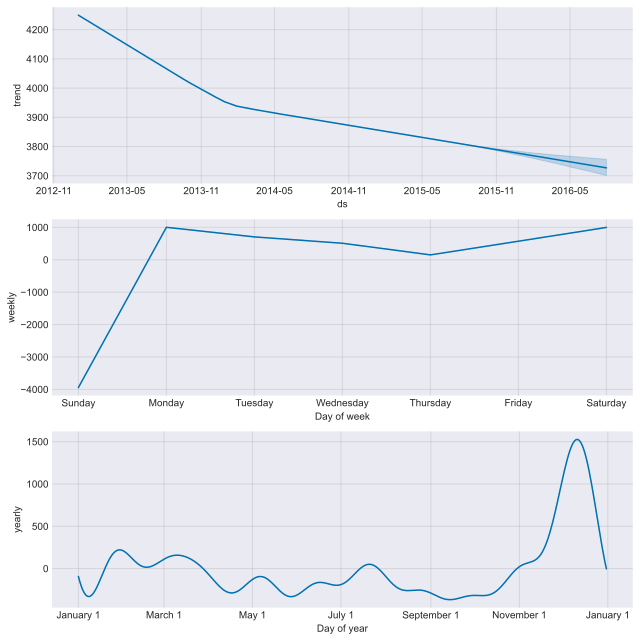

In [104]:
m.plot_components(forecast);

Overall trend is decreasing with one changepoint in the trend. Sundays has a negative impact in the sales. Sales has a peak around the christmas holidays!

### Modeling (only) days when the store is open! 
-------
As we saw earlier, sales are zero on days store is closed. Including them affects the predictions quite considerably. It makes more sense to model the sales on the days when the store is open!

In [105]:
df_p2 = df_s1[df_s1['Open'] > 0][['Sales']].copy()

df_p2['Date'] = df_s1[df_s1['Open'] > 0].index

df_p2.sort_index(inplace = True)

df_p2.columns = ['y', 'ds']

df_p2.head(10) # notice that some days are omitted corresponding to holidays and sundays when the store is closed 

,y,ds
Date,,
2013-01-02,5530,2013-01-02
2013-01-03,4327,2013-01-03
2013-01-04,4486,2013-01-04
2013-01-05,4997,2013-01-05
2013-01-07,7176,2013-01-07
2013-01-08,5580,2013-01-08
2013-01-09,5471,2013-01-09
2013-01-10,4892,2013-01-10
2013-01-11,4881,2013-01-11


18:16:58 - cmdstanpy - INFO - Chain [1] start processing
18:16:58 - cmdstanpy - INFO - Chain [1] done processing


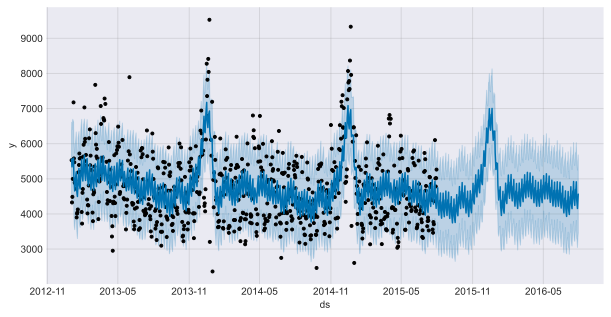

In [106]:
# initiate Prophet, fit and forecast 

m2 = Prophet()

m2.fit(df_p2)

ft_df2 = m2.make_future_dataframe(periods = 365)

forecast2 = m2.predict(ft_df2)

fig, axes = plt.subplots(figsize = (10,5))

m2.plot(forecast2, ax = axes);


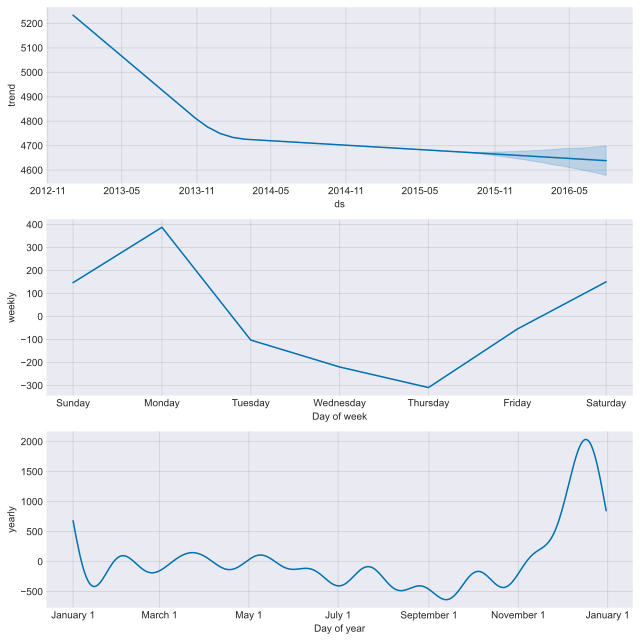

In [107]:
m2.plot_components(forecast2);

Since prophet is a continous model,it will still have a predictions for e.g sundays, however we will ignore them as we know they do not make sense. It is clear from the weekly component that the model just interpolates between Saturday and mondays for which we provided the data for!

### Incorporating Holidays and exogenous regressors to the Model
------

18:17:11 - cmdstanpy - INFO - Chain [1] start processing
18:17:11 - cmdstanpy - INFO - Chain [1] done processing


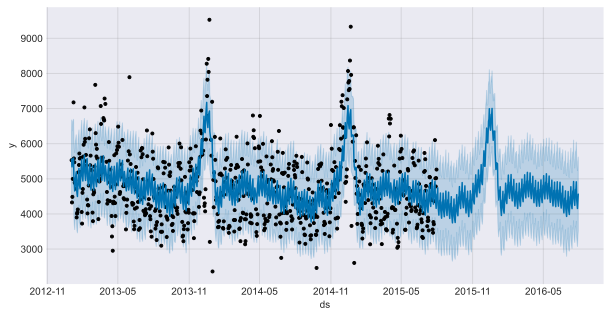

In [108]:
m3 = Prophet()

m3.add_country_holidays(country_name = 'DE') # 

m3.fit(df_p2)

ft_df3 = m3.make_future_dataframe(periods = 365)

forecast3 = m3.predict(ft_df3)

fig, axes = plt.subplots(figsize = (10,5))

m3.plot(forecast3, ax = axes);


In [109]:
m3.train_holiday_names

0             New Year's Day
1                Good Friday
2              Easter Monday
3                  Labor Day
4              Ascension Day
5                Whit Monday
6           German Unity Day
7              Christmas Day
8    Second Day of Christmas
dtype: object

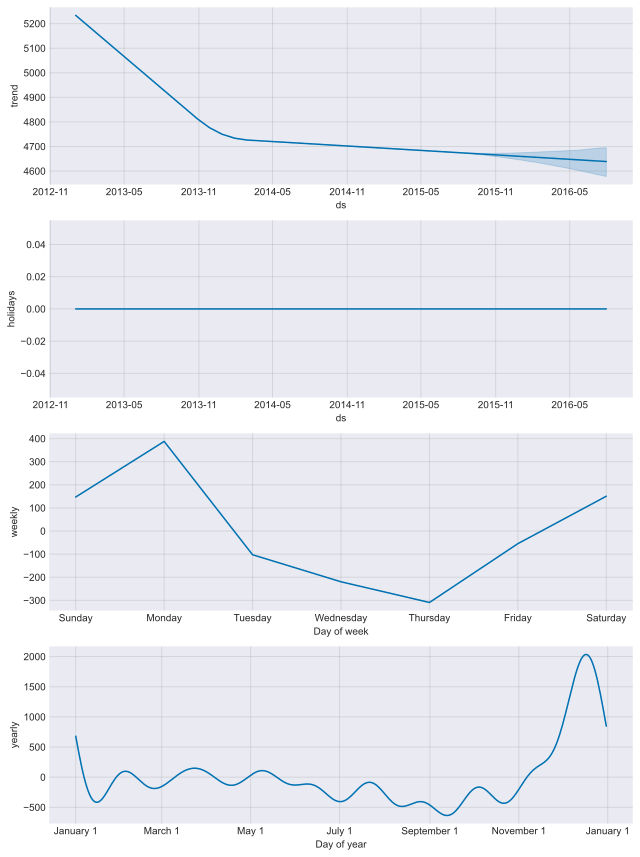

In [110]:
m3.plot_components(forecast3);

Now we have a holiday component that does not seem to have an influence on the model given the country choice (Germany) we have made. 

In [111]:
# Instead of the lazy method of automatically adding holidays to the model for a particular country, we can do it in a more customized way at the level of the data 
# 0 = no holiday
# a = public holiday
# b = easther
# c = christmas

df_s1['StateHoliday'].unique()


array(['0', 'a', 'b', 'c'], dtype=object)

In [112]:
# school holidays are only labelled in a binary way 

df_s1['SchoolHoliday'].unique()

array([1, 0])

In [113]:
df_s1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


In [114]:
df_p['open'] = df_s1['Open']
df_p['promo'] = df_s1['Promo']

df_p[['StH1','StH2', 'StH3']] = pd.get_dummies(df_s1['StateHoliday'], drop_first=True) # dropfirst = True because 4th value is redundant to have a column for

df_p['schH'] = df_s1['SchoolHoliday']


df_p.head(20)

,y,ds,open,promo,StH1,StH2,StH3,schH
Date,,,,,,,,
2013-01-01,0,2013-01-01,0,0,1,0,0,1
2013-01-02,5530,2013-01-02,1,0,0,0,0,1
2013-01-03,4327,2013-01-03,1,0,0,0,0,1
2013-01-04,4486,2013-01-04,1,0,0,0,0,1
2013-01-05,4997,2013-01-05,1,0,0,0,0,1
2013-01-06,0,2013-01-06,0,0,0,0,0,1
2013-01-07,7176,2013-01-07,1,1,0,0,0,1
2013-01-08,5580,2013-01-08,1,1,0,0,0,1
2013-01-09,5471,2013-01-09,1,1,0,0,0,1


In [115]:
m4 = Prophet()

m4.add_regressor('open', mode = 'multiplicative')
m4.add_regressor('promo', mode = 'additive')
m4.add_regressor('StH1', mode = 'additive')
m4.add_regressor('StH2', mode = 'additive')
m4.add_regressor('StH3', mode = 'additive')
m4.add_regressor('schH', mode = 'additive')

m4.fit(df_p)


18:17:33 - cmdstanpy - INFO - Chain [1] start processing
18:17:33 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
ft_df4 = m4.make_future_dataframe(periods = 365)

# boolean split for train and test 

train_idx = ft_df4['ds'].isin(df_p.index)

test_idx = ~train_idx

In [117]:
# need to add the new regrossors to the ft_df4

regressors = df_p.columns.tolist()[-6:]

for r in regressors:

    ft_df4.loc[train_idx, r] = df_p[r].tolist()

In [118]:
ft_df4.head(10)

,ds,open,promo,StH1,StH2,StH3,schH
0,2013-01-01,0.0,0.0,1.0,0.0,0.0,1.0
1,2013-01-02,1.0,0.0,0.0,0.0,0.0,1.0
2,2013-01-03,1.0,0.0,0.0,0.0,0.0,1.0
3,2013-01-04,1.0,0.0,0.0,0.0,0.0,1.0
4,2013-01-05,1.0,0.0,0.0,0.0,0.0,1.0
5,2013-01-06,0.0,0.0,0.0,0.0,0.0,1.0
6,2013-01-07,1.0,1.0,0.0,0.0,0.0,1.0
7,2013-01-08,1.0,1.0,0.0,0.0,0.0,1.0
8,2013-01-09,1.0,1.0,0.0,0.0,0.0,1.0
9,2013-01-10,1.0,1.0,0.0,0.0,0.0,1.0


In [119]:
# doing the same for the test set which would require quite some work because we need to assign each value of the exogenous predictor to a value 

# for the 'open' feature it is easier as we know the 6th day of the week is sunday 

ft_df4.loc[test_idx, 'open'] = ft_df4.loc[test_idx, 'ds'].apply(lambda x: 1.0 * (x.weekday() != 6)) 

In [120]:
# being very lazy, for other features we simply copy the last 365 values in the training set 

for r in regressors[1:]:

    ft_df4.loc[test_idx, r] = df_p.iloc[-365:][r].tolist()


In [121]:
ft_df4.tail(10)

,ds,open,promo,StH1,StH2,StH3,schH
1297,2016-07-21,1.0,0.0,0.0,0.0,0.0,0.0
1298,2016-07-22,1.0,0.0,0.0,0.0,0.0,0.0
1299,2016-07-23,1.0,0.0,0.0,0.0,0.0,0.0
1300,2016-07-24,0.0,0.0,0.0,0.0,0.0,0.0
1301,2016-07-25,1.0,0.0,0.0,0.0,0.0,0.0
1302,2016-07-26,1.0,1.0,0.0,0.0,0.0,1.0
1303,2016-07-27,1.0,1.0,0.0,0.0,0.0,1.0
1304,2016-07-28,1.0,1.0,0.0,0.0,0.0,1.0
1305,2016-07-29,1.0,1.0,0.0,0.0,0.0,1.0
1306,2016-07-30,1.0,1.0,0.0,0.0,0.0,1.0


In [122]:
forecast4 = m4.predict(ft_df4)

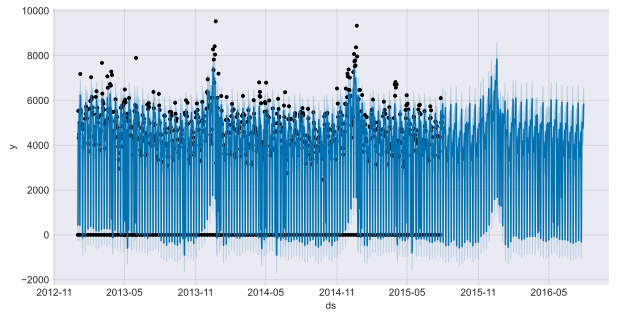

In [123]:
fig, axes = plt.subplots(figsize = (10,5))

m4.plot(forecast4, ax = axes);


Model does still give negative values. It would be more useful to simply remove the data when the store is closed! This will indicate that we can also get rid of 'open' regressor.

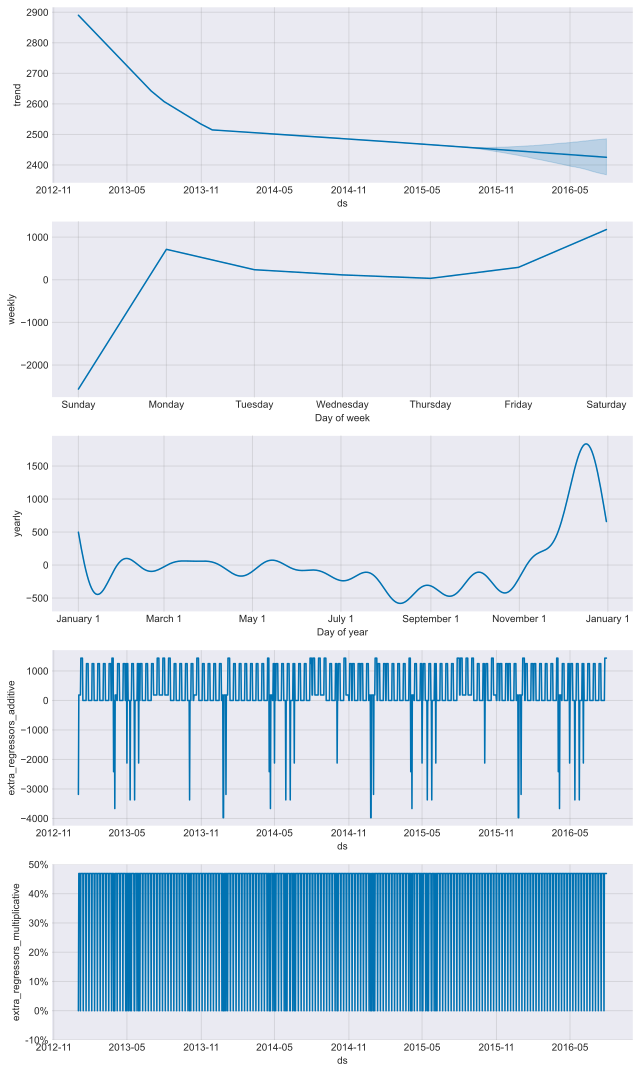

In [124]:
m4.plot_components(forecast4);

### Cross Validation
----

In [125]:
from prophet.diagnostics import cross_validation, performance_metrics


In [126]:
df_cv = cross_validation(m, initial = '730 days', period = '30 days', horizon = '60 days')

  0%|          | 0/6 [00:00<?, ?it/s]

18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing
18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing
18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing
18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing
18:18:05 - cmdstanpy - INFO - Chain [1] start processing
18:18:05 - cmdstanpy - INFO - Chain [1] done processing
18:18:05 - cmdstanpy - INFO - Chain [1] start processing
18:18:05 - cmdstanpy - INFO - Chain [1] done processing


In [127]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-03,4608.117929,3235.994566,6073.896480,5023,2015-01-02
1,2015-01-04,-445.895878,-1812.607772,967.792027,0,2015-01-02
2,2015-01-05,4569.246667,3042.596073,6025.203758,6239,2015-01-02
3,2015-01-06,4183.658054,2705.282190,5615.340214,4574,2015-01-02
4,2015-01-07,3945.215415,2470.760275,5443.436581,4796,2015-01-02
...,...,...,...,...,...,...
355,2015-07-27,4785.406289,3334.412194,6142.958184,6102,2015-06-01
356,2015-07-28,4460.816308,3043.361673,5882.590136,5011,2015-06-01
357,2015-07-29,4246.225991,2729.482411,5669.564931,4782,2015-06-01
358,2015-07-30,3870.633457,2428.923874,5278.098234,5020,2015-06-01


In [128]:
pm = performance_metrics(df_cv)
pm

,horizon,mse,rmse,mae,mdape,smape,coverage
0,6 days,2.222852e+06,1490.923168,919.819675,0.137619,0.550437,0.805556
1,7 days,1.586789e+06,1259.678212,758.085231,0.132822,0.491632,0.833333
2,8 days,1.460745e+06,1208.612953,704.556399,0.123564,0.486085,0.888889
3,9 days,1.165083e+06,1079.390242,688.981035,0.144444,0.453627,0.916667
4,10 days,5.045498e+05,710.316655,578.365588,0.155410,0.460249,0.944444
5,11 days,4.961911e+05,704.408366,570.075342,0.147699,0.403540,0.944444
6,12 days,8.580966e+05,926.335032,634.441981,0.147699,0.450475,0.944444
7,13 days,8.282299e+05,910.071362,606.779668,0.137121,0.442051,0.944444
8,14 days,7.838023e+05,885.326091,567.668827,0.125517,0.433277,0.944444
9,15 days,6.566429e+05,810.335045,498.623190,0.102969,0.414787,0.972222


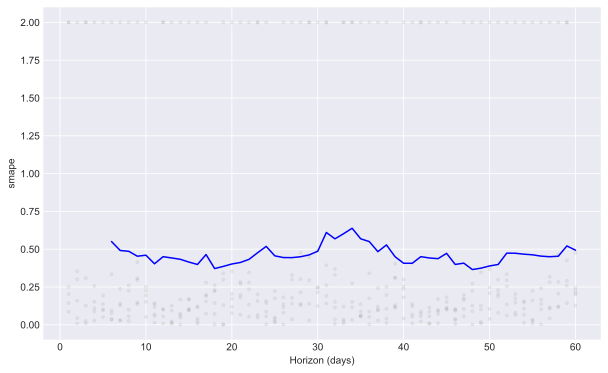

In [130]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric = 'smape');

  0%|          | 0/6 [00:00<?, ?it/s]

18:18:27 - cmdstanpy - INFO - Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing
18:18:27 - cmdstanpy - INFO - Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing
18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:28 - cmdstanpy - INFO - Chain [1] done processing
18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:28 - cmdstanpy - INFO - Chain [1] done processing
18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:28 - cmdstanpy - INFO - Chain [1] done processing
18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:28 - cmdstanpy - INFO - Chain [1] done processing


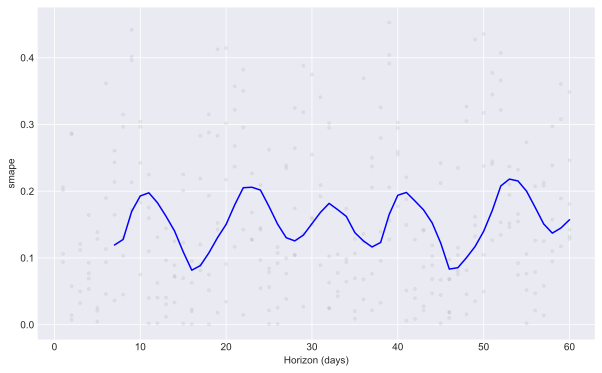

In [131]:
# second model 

df_cv2 = cross_validation(m2, initial = '730 days', period = '30 days', horizon = '60 days')

pm2 = performance_metrics(df_cv2)

plot_cross_validation_metric(df_cv2, metric = 'smape');

  0%|          | 0/6 [00:00<?, ?it/s]

18:18:34 - cmdstanpy - INFO - Chain [1] start processing
18:18:34 - cmdstanpy - INFO - Chain [1] done processing
18:18:34 - cmdstanpy - INFO - Chain [1] start processing
18:18:34 - cmdstanpy - INFO - Chain [1] done processing
18:18:34 - cmdstanpy - INFO - Chain [1] start processing
18:18:35 - cmdstanpy - INFO - Chain [1] done processing
18:18:35 - cmdstanpy - INFO - Chain [1] start processing
18:18:35 - cmdstanpy - INFO - Chain [1] done processing
18:18:35 - cmdstanpy - INFO - Chain [1] start processing
18:18:35 - cmdstanpy - INFO - Chain [1] done processing
18:18:35 - cmdstanpy - INFO - Chain [1] start processing
18:18:35 - cmdstanpy - INFO - Chain [1] done processing


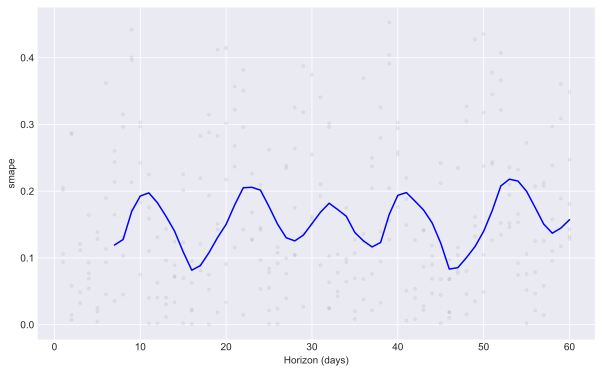

In [132]:
# third model 

df_cv3 = cross_validation(m3, initial = '730 days', period = '30 days', horizon = '60 days')

pm3 = performance_metrics(df_cv3)

plot_cross_validation_metric(df_cv3, metric = 'smape');

  0%|          | 0/6 [00:00<?, ?it/s]

18:18:39 - cmdstanpy - INFO - Chain [1] start processing
18:18:39 - cmdstanpy - INFO - Chain [1] done processing
18:18:39 - cmdstanpy - INFO - Chain [1] start processing
18:18:39 - cmdstanpy - INFO - Chain [1] done processing
18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:40 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
18:18:41 - cmdstanpy - INFO - Chain [1] start processing
18:18:41 - cmdstanpy - INFO - Chain [1] done processing


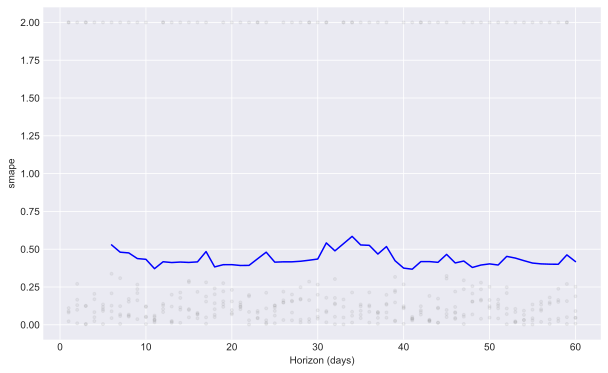

In [133]:
# 4th model 

df_cv4 = cross_validation(m4, initial = '730 days', period = '30 days', horizon = '60 days')

pm4 = performance_metrics(df_cv4)

plot_cross_validation_metric(df_cv4, metric = 'smape');

In [134]:
# Compare mean smape for all the models 
pms = [pm, pm2, pm3, pm4]

for i, pm in enumerate(pms):
    if i == 0:
        print(f"Mean SMAPE for Model m {pms[i]['smape'].mean()}")
    else: 
        print(f"Mean SMAPE for Model m{i+1} {pms[i]['smape'].mean()}")

Mean SMAPE for Model m 0.4617555394001824
Mean SMAPE for Model m2 0.15376017796548117
Mean SMAPE for Model m3 0.15370577685199294
Mean SMAPE for Model m4 0.4359443276337427


Notice that for models where we used data with closed stores SMAPE is larger (m and m4). Inclusion of exogenous regressor did reduce the error but not significantly. 

### Change point detection
--------

In [84]:
from prophet.plot import add_changepoints_to_plot

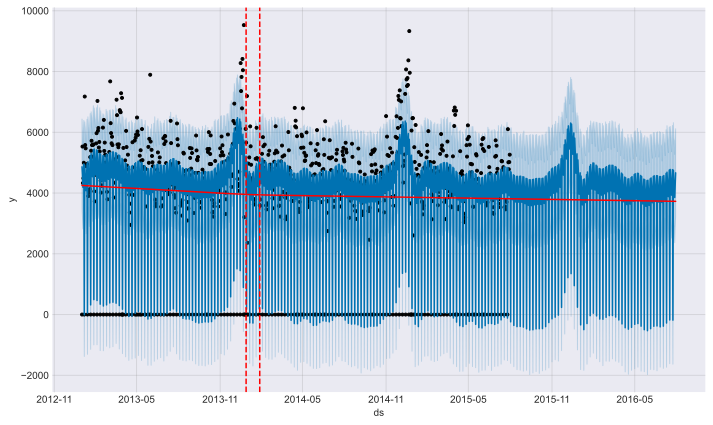

In [135]:
fig = m.plot(forecast)

a= add_changepoints_to_plot(fig.gca(), m, forecast)



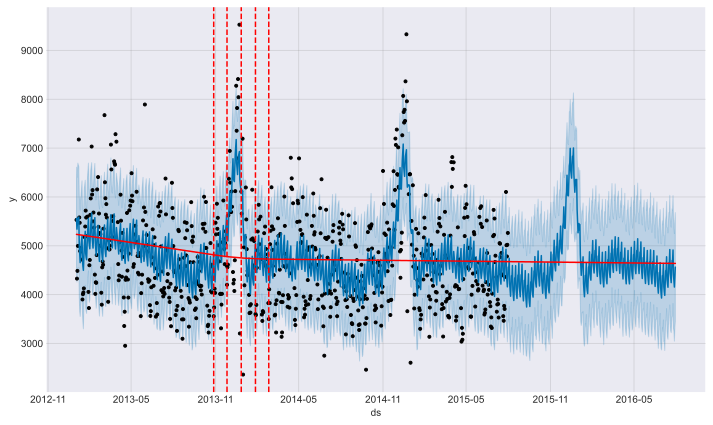

In [136]:
fig = m2.plot(forecast2)

a= add_changepoints_to_plot(fig.gca(), m2, forecast2)

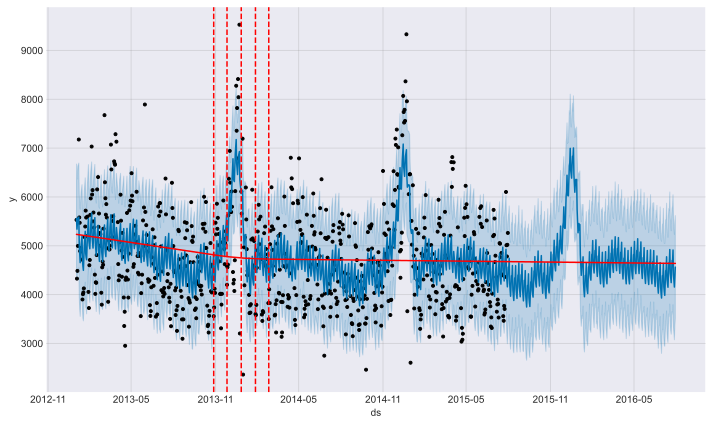

In [137]:
fig = m3.plot(forecast3)

a= add_changepoints_to_plot(fig.gca(), m3, forecast3)

If the trend changes are being overfit (too much flexible) or underfit (not enough flexible), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By defauly, this parameter is set to 0.05. Increasing it will make the trend more flexible